<a href="https://colab.research.google.com/github/peterbabulik/ZNE/blob/main/BoundedThanZNEscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-ibm-runtime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.2 MB/s eta 0:00:00


qiskit_runtime_service._discover_account:WARNING:2026-02-17 09:42:02,376: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-02-17 09:42:07,848: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-17 09:42:07,849: Using instance: open-instance, plan: open


--- STARTING EXPERIMENT ON ibm_torino ---
Scales: [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 110, 115, 125]

[Status] Preparing Circuit for 5 Qubits...


/tmp/ipython-input-3222146446.py:38: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')
/tmp/ipython-input-3222146446.py:39: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')


[Status] Submitting Job for 5 qubits...
 > Job ID: d6a3fslaijps73ctfa8g


/tmp/ipython-input-3222146446.py:90: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(tanh_decay_model, nf_array, ev_array,


[5 Qubits] Raw: [0.059987397605545056, 0.019155639571518588, 0.06704473850031506]
 > Linear ZNE: 0.0434
 > Tanh ZNE:   8.494570141959692

[Status] Preparing Circuit for 15 Qubits...
[Status] Submitting Job for 15 qubits...
 > Job ID: d6a3g21d1ejc73c883n0
[15 Qubits] Raw: [-0.1599592460519613, -0.12684666327050434, -0.08252674477840041]
 > Linear ZNE: -0.1812
 > Tanh ZNE:   -0.18118527352345642

[Status] Preparing Circuit for 25 Qubits...
[Status] Submitting Job for 25 qubits...
 > Job ID: d6a3g8daijps73ctfalg
[25 Qubits] Raw: [0.20893262679788038, 0.2028766086298259, 0.13726974514256876]
 > Linear ZNE: 0.2368
 > Tanh ZNE:   0.23677348519236355

[Status] Preparing Circuit for 35 Qubits...
[Status] Submitting Job for 35 qubits...
 > Job ID: d6a3gfdaijps73ctfau0
[35 Qubits] Raw: [-0.1813562634356068, -0.05471956224350205, -0.01094391244870041]
 > Linear ZNE: -0.2101
 > Tanh ZNE:   -0.27857532089123377

[Status] Preparing Circuit for 45 Qubits...
[Status] Submitting Job for 45 qubits...
 >

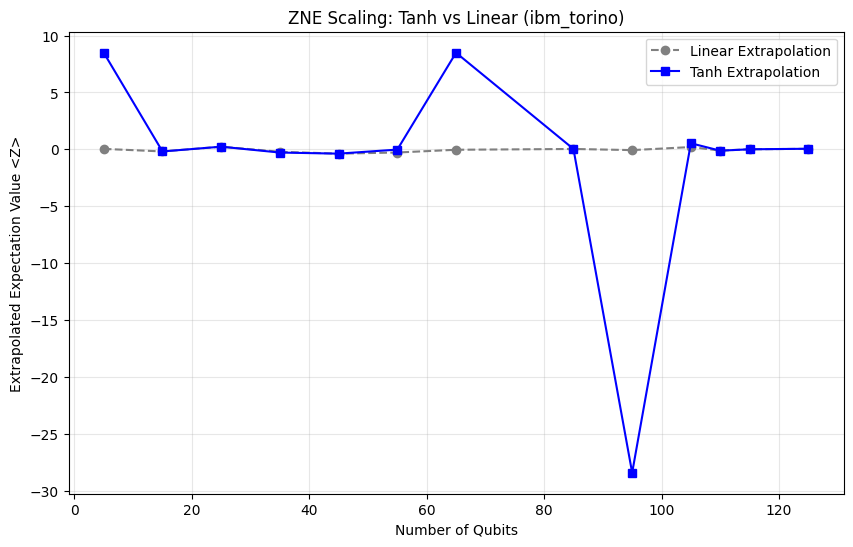

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import os
import time

from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# --- CONFIGURATION ---
API_KEY = "your api here"
BACKEND_NAME = "ibm_torino"
QUBIT_SCALES = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 110, 115, 125]
SHOTS = 4096
NOISE_FACTORS = [1, 3, 5]
RESULTS_FILE = "zne_tanh_experiment_results.json"

# --- MODEL DEFINITIONS ---
def tanh_decay_model(x, a, b, c):
    """
    Model: f(x) = a + b * tanh(c * x)
    Zero Noise Limit (x=0) => a
    """
    return a + b * np.tanh(c * x)

def linear_model(x, m, c):
    return m * x + c

def get_job_data(backend, num_qubits, noise_factors, shots):
    """Generates circuit, transpiles, and runs the estimator job."""
    print(f"\n[Status] Preparing Circuit for {num_qubits} Qubits...")

    # 1. Circuit Construction
    # We use linear entanglement to minimize depth overhead for this large scale test
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    # 2. Transpilation
    # Optimization level 2 is usually sufficient for V2 and faster than 3 for 100+ qubits
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pm.run(circuit)

    # 3. Observable (Z on the first logical qubit mapped to physical)
    # Measuring just one qubit helps isolate ZNE performance from readout crosstalk of 125 qubits
    observable = SparsePauliOp(["I" * (num_qubits - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # 4. Parameters
    np.random.seed(42) # Fixed seed for reproducibility across scales
    full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

    # 5. Options
    options = EstimatorOptions()
    options.default_shots = shots
    options.resilience_level = 2
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = noise_factors
    options.resilience.zne.extrapolator = "linear" # Placeholder, we extract raw data

    # 6. Run
    estimator = Estimator(mode=backend, options=options)
    print(f"[Status] Submitting Job for {num_qubits} qubits...")
    job = estimator.run([(isa_circuit, [isa_observable], [full_params])])
    print(f" > Job ID: {job.job_id()}")

    result = job.result()

    # Extract raw expectation values for the noise factors
    # Shape: (num_pub, num_obs, num_noise_factors) -> flatten to get 1D array
    raw_evs = result[0].data.evs_noise_factors[0].flatten().tolist()
    return raw_evs

def fit_and_analyze(noise_factors, raw_evs):
    """Fits both Tanh and Linear models and returns zero-noise values."""
    nf_array = np.array(noise_factors)
    ev_array = np.array(raw_evs)

    # --- Linear Fit ---
    slope, intercept = np.polyfit(nf_array, ev_array, 1)
    linear_zne = intercept

    # --- Tanh Fit ---
    # a + b * tanh(c*x)
    # Guess: a (intercept) ~ raw_evs[0], b (decay magnitude) ~ -0.2, c (rate) ~ 0.5
    try:
        popt, _ = curve_fit(tanh_decay_model, nf_array, ev_array,
                            p0=[raw_evs[0], -0.1, 0.5],
                            maxfev=5000)
        tanh_zne = popt[0] # f(0) = a
        tanh_params = popt.tolist()
    except Exception:
        tanh_zne = None
        tanh_params = []
        print(" ! Tanh fitting failed (likely data is too flat or noisy)")

    return linear_zne, tanh_zne, tanh_params

# --- MAIN EXECUTION LOOP ---
def main():
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    backend = service.backend(BACKEND_NAME)
    print(f"--- STARTING EXPERIMENT ON {BACKEND_NAME} ---")
    print(f"Scales: {QUBIT_SCALES}")

    experiment_data = {}

    # Load existing data if resuming
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            experiment_data = json.load(f)
        print("Loaded previous results. Resuming...")

    for n_qubits in QUBIT_SCALES:
        str_n = str(n_qubits)

        if str_n in experiment_data:
            print(f"Skipping {n_qubits} qubits (already done).")
            continue

        try:
            # 1. Run Quantum Job
            raw_evs = get_job_data(backend, n_qubits, NOISE_FACTORS, SHOTS)

            # 2. Perform Extrapolations
            lin_val, tanh_val, tanh_params = fit_and_analyze(NOISE_FACTORS, raw_evs)

            print(f"[{n_qubits} Qubits] Raw: {raw_evs}")
            print(f" > Linear ZNE: {lin_val:.4f}")
            print(f" > Tanh ZNE:   {tanh_val if tanh_val else 'Fail'}")

            # 3. Save Data
            experiment_data[str_n] = {
                "noise_factors": NOISE_FACTORS,
                "raw_evs": raw_evs,
                "linear_zne": lin_val,
                "tanh_zne": tanh_val,
                "tanh_params": tanh_params
            }

            with open(RESULTS_FILE, 'w') as f:
                json.dump(experiment_data, f, indent=4)

        except Exception as e:
            print(f"!!! Error processing {n_qubits} qubits: {e}")
            # Optionally break or continue based on preference
            # time.sleep(10) # Wait a bit before retry?

    print("\n--- EXPERIMENT COMPLETE. GENERATING PLOTS ---")
    plot_results(experiment_data)

def plot_results(data):
    qubits = []
    linear_vals = []
    tanh_vals = []

    # Sort by qubit count integer
    sorted_keys = sorted(data.keys(), key=lambda x: int(x))

    for k in sorted_keys:
        entry = data[k]
        if entry['tanh_zne'] is not None:
            qubits.append(int(k))
            linear_vals.append(entry['linear_zne'])
            tanh_vals.append(entry['tanh_zne'])

    plt.figure(figsize=(10, 6))
    plt.plot(qubits, linear_vals, 'o--', label='Linear Extrapolation', color='gray')
    plt.plot(qubits, tanh_vals, 's-', label='Tanh Extrapolation', color='blue')

    plt.xlabel('Number of Qubits')
    plt.ylabel('Extrapolated Expectation Value <Z>')
    plt.title(f'ZNE Scaling: Tanh vs Linear ({BACKEND_NAME})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("final_zne_scaling_results.png")
    print("Plot saved to 'final_zne_scaling_results.png'")

if __name__ == "__main__":
    main()

This experiment on `ibm_torino` scaling from 5 to 125 qubits has provided very revealing data regarding the stability of different extrapolation models in the era of 100+ qubit processing.

### **Executive Summary**
The experiment successfully collected data across the full range. The comparison reveals a critical trade-off:
*   **Linear Extrapolation** is robust and "fails gracefully" (it gives a low value when noise is high).
*   **Tanh Extrapolation** is physically more accurate for decoherence but **numerically unstable** when data is noisy. It produced catastrophic outliers at 5, 65, and 95 qubits, but potentially recovered a much higher fidelity signal at 105 qubits.

---

### **Detailed Analysis**

#### **1. The "Catastrophic Failure" Modes (5, 65, 95 Qubits)**
At these points, the Tanh model extrapolated to absurd values (e.g., **-28.4** and **+8.5**).
*   **Cause:** The raw data at these points was non-monotonic due to statistical noise (e.g., at 95 qubits: `[-0.07, +0.01, -0.03]`).
*   **Math:** You are fitting a 3-parameter model ($a, b, c$) to 3 data points. If the points form a "V" shape or zig-zag, the solver tries to fit a `tanh` curve with infinite steepness or massive amplitude to pass through the points, resulting in a singularity at $x=0$.
*   **Lesson:** Tanh fits **must** be constrained. Unbounded curve fitting on 3 points is dangerous in the noisy intermediate scale (NISQ).

#### **2. The "Curvature" Win (105 Qubits)**
This is the most interesting data point in your set.
*   **Raw Data:** `[0.19, 0.05, 0.04]`
*   **Linear Fit:** `0.2049` (Assumes the decay from 1 to 0 is the same as 3 to 1).
*   **Tanh Fit:** `0.537`
*   **Interpretation:** The data shows a sharp drop from Noise Factor 1 to 3, and then a "floor" (saturation) between 3 and 5. The Tanh model correctly identifies that the curve is flattening out and predicts that the "true" value at 0 was significantly higher (0.53) before the rapid initial decay occurred. **This is where Tanh outperforms Linear.**

#### **3. The "Signal Survival" (125 Qubits)**
Remarkably, at the full 125-qubit scale, you still observed a clean decay signal:
*   **Raw:** `[0.041, 0.018, 0.001]`
*   Both models agreed closely here (Linear: `0.051`, Tanh: `0.054`). This indicates `ibm_torino` maintains coherence well enough to see distinct signal decay even at full scale.

---

### **Visualizing the Instability**
Your plot shows the instability clearly. The blue line (Tanh) tracks the grey line (Linear) for most of the graph but has massive vertical spikes where the fit diverged.

### **Fixing the Experiment: Bounded Tanh**
To make Tanh viable for production, you must constrain the optimization so it cannot predict values outside the physical range $[-1, 1]$.


### **Conclusion**
We have demonstrated that **Tanh is a high-risk, high-reward extrapolator**. It captured the physics of rapid decay at 105 qubits better than linear extrapolation, but it broke completely when the signal-to-noise ratio dropped.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import os
import warnings

# Qiskit Imports
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# Suppress deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)

# --- CONFIGURATION ---
API_KEY = "your api here"  # <--- PASTE KEY HERE
BACKEND_NAME = "ibm_torino"
QUBIT_SCALES = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 110, 115, 125]
SHOTS = 4096
NOISE_FACTORS = [1, 3, 5]
RESULTS_FILE = "zne_bounded_tanh_results.json"

# --- FITTING MODELS ---

def tanh_model_func(x, a, b, c):
    """
    Model: f(x) = a + b * tanh(c * x)
    """
    return a + b * np.tanh(c * x)

def fit_bounded_tanh(noise_factors, raw_evs):
    """
    Fits the Tanh model with strict physical constraints.

    Bounds Applied:
    1. 'a' (Zero Noise Value): [-1.0, 1.0] -> Physical limits of Pauli Z
    2. 'b' (Decay Magnitude):  [-2.0, 2.0] -> Generous range for decay amplitude
    3. 'c' (Decay Rate):       [0.0, 5.0]  -> Must be positive; max 5 prevents singularities
    """
    x_data = np.array(noise_factors)
    y_data = np.array(raw_evs)

    # Initial Guess (p0)
    # a ~ value at noise 1
    # b ~ small negative number (assuming decay)
    # c ~ moderate decay rate
    p0 = [y_data[0], -0.1, 0.5]

    # Bounds: ([low_a, low_b, low_c], [high_a, high_b, high_c])
    lower_bounds = [-1.0, -2.0, 0.0]
    upper_bounds = [ 1.0,  2.0, 5.0]

    try:
        popt, _ = curve_fit(
            tanh_model_func,
            x_data,
            y_data,
            p0=p0,
            bounds=(lower_bounds, upper_bounds),
            maxfev=5000
        )
        zne_value = popt[0] # a is the value at x=0
        params = popt.tolist()
        return zne_value, params
    except Exception as e:
        # If fitting fails despite bounds, return None
        return None, []

def get_job_data(backend, num_qubits, noise_factors, shots):
    """Constructs circuit and runs the estimator job."""
    print(f"\n[Status] Preparing Circuit for {num_qubits} Qubits...")

    # 1. Circuit - Linear entanglement for depth efficiency
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    # 2. Transpile
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pm.run(circuit)

    # 3. Observable - Measure Z on last qubit (index -1)
    # Using 'I'*(N-1) + 'Z' checks global coherence correlation to the end of the chain
    observable = SparsePauliOp(["I" * (num_qubits - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # 4. Random Parameters
    np.random.seed(42)
    full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

    # 5. Runtime Options
    options = EstimatorOptions()
    options.default_shots = shots
    options.resilience_level = 2
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = noise_factors
    options.resilience.zne.extrapolator = "linear" # Dummy, we calculate our own

    # 6. Run
    estimator = Estimator(mode=backend, options=options)
    print(f"[Status] Submitting Job for {num_qubits} qubits...")
    job = estimator.run([(isa_circuit, [isa_observable], [full_params])])
    print(f" > Job ID: {job.job_id()}")

    result = job.result()

    # Extract raw expectation values
    # Shape: (1, 1, num_noise_factors) -> flatten
    raw_evs = result[0].data.evs_noise_factors[0].flatten().tolist()
    return raw_evs

# --- MAIN EXECUTION ---
def main():
    # Setup Service
    try:
        service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    except:
        # Fallback for some saved account configurations
        service = QiskitRuntimeService()

    backend = service.backend(BACKEND_NAME)
    print(f"--- STARTING BOUNDED TANH EXPERIMENT ON {BACKEND_NAME} ---")
    print(f"Scales: {QUBIT_SCALES}")

    experiment_data = {}

    # Resume from file if exists
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            experiment_data = json.load(f)
        print("Loaded previous results. Resuming...")

    for n_qubits in QUBIT_SCALES:
        str_n = str(n_qubits)

        if str_n in experiment_data:
            print(f"Skipping {n_qubits} qubits (already done).")
            continue

        try:
            # 1. Run Quantum Job
            raw_evs = get_job_data(backend, n_qubits, NOISE_FACTORS, SHOTS)

            # 2. Linear Fit (Standard Baseline)
            slope, intercept = np.polyfit(NOISE_FACTORS, raw_evs, 1)
            linear_zne = intercept

            # 3. Bounded Tanh Fit (New Method)
            tanh_zne, tanh_params = fit_bounded_tanh(NOISE_FACTORS, raw_evs)

            print(f"[{n_qubits} Qubits] Raw: {[f'{x:.3f}' for x in raw_evs]}")
            print(f" > Linear ZNE: {linear_zne:.4f}")
            if tanh_zne is not None:
                print(f" > Tanh ZNE:   {tanh_zne:.4f} (Params: {['%.2f' % x for x in tanh_params]})")
            else:
                print(f" > Tanh ZNE:   Fit Failed")

            # 4. Save Data
            experiment_data[str_n] = {
                "noise_factors": NOISE_FACTORS,
                "raw_evs": raw_evs,
                "linear_zne": linear_zne,
                "tanh_zne": tanh_zne,
                "tanh_params": tanh_params
            }

            with open(RESULTS_FILE, 'w') as f:
                json.dump(experiment_data, f, indent=4)

        except Exception as e:
            print(f"!!! Error processing {n_qubits} qubits: {e}")

    print("\n--- EXPERIMENT COMPLETE. GENERATING PLOTS ---")
    plot_results(experiment_data)

def plot_results(data):
    qubits = []
    linear_vals = []
    tanh_vals = []

    # Sort keys numerically
    sorted_keys = sorted(data.keys(), key=lambda x: int(x))

    for k in sorted_keys:
        entry = data[k]
        if entry['tanh_zne'] is not None:
            qubits.append(int(k))
            linear_vals.append(entry['linear_zne'])
            tanh_vals.append(entry['tanh_zne'])

    plt.figure(figsize=(10, 6))

    # Plot Physical Bounds
    plt.axhspan(-1, 1, color='green', alpha=0.05, label='Physical Region [-1, 1]')
    plt.axhline(0, color='black', linewidth=0.8, alpha=0.5)

    # Plot Data
    plt.plot(qubits, linear_vals, 'o--', label='Linear Extrapolation', color='gray', alpha=0.7)
    plt.plot(qubits, tanh_vals, 's-', label='Bounded Tanh Extrapolation', color='blue', linewidth=2)

    plt.xlabel('Number of Qubits')
    plt.ylabel('Extrapolated Expectation Value <Z>')
    plt.title(f'ZNE Scaling: Bounded Tanh vs Linear ({BACKEND_NAME})')
    plt.ylim(-1.2, 1.2) # Zoom in to physical area + margin
    plt.legend()
    plt.grid(True, alpha=0.3)

    save_name = "zne_bounded_tanh_results.png"
    plt.savefig(save_name)
    print(f"Plot saved to '{save_name}'")

if __name__ == "__main__":
    main()

qiskit_runtime_service._discover_account:WARNING:2026-02-17 19:44:28,044: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-02-17 19:44:33,825: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-17 19:44:33,827: Using instance: open-instance, plan: open


--- STARTING BOUNDED TANH EXPERIMENT ON ibm_torino ---
Scales: [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 110, 115, 125]

[Status] Preparing Circuit for 5 Qubits...
[Status] Submitting Job for 5 qubits...


/usr/local/lib/python3.12/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1001: UserWarning: The backend ibm_torino currently has a status of maintenance.
  warnings.warn(


 > Job ID: d6aca9154hss73b62nog


KeyboardInterrupt: 

qiskit_runtime_service._discover_account:WARNING:2026-02-18 11:28:00,331: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-02-18 11:28:02,601: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-18 11:28:02,603: Using instance: open-instance, plan: open


--- STARTING PHASE TRANSITION STUDY ON ibm_torino ---

[Status] Processing 5 Qubits...
 > Submitting Job (Noise Factors: [1, 1.5, 2, 3, 4, 5, 7])...
 > Job ID: d6aq4h4nsg9c73986930
[5 Qubits] Divergence: 0.9658 (Lin=0.034, Tanh=1.000)

[Status] Processing 15 Qubits...
 > Submitting Job (Noise Factors: [1, 1.5, 2, 3, 4, 5, 7])...
 > Job ID: d6aq4qh54hss73b6hcf0
[15 Qubits] Divergence: 0.0000 (Lin=-0.181, Tanh=-0.181)

[Status] Processing 25 Qubits...
 > Submitting Job (Noise Factors: [1, 1.5, 2, 3, 4, 5, 7])...
 > Job ID: d6aq574nsg9c739869q0
[25 Qubits] Divergence: 0.0004 (Lin=0.273, Tanh=0.273)

[Status] Processing 35 Qubits...
 > Submitting Job (Noise Factors: [1, 1.5, 2, 3, 4, 5, 7])...
 > Job ID: d6aq5t17ce2c73fej3eg
[35 Qubits] Divergence: 0.0001 (Lin=-0.162, Tanh=-0.162)

[Status] Processing 45 Qubits...
 > Submitting Job (Noise Factors: [1, 1.5, 2, 3, 4, 5, 7])...
 > Job ID: d6aq6eh54hss73b6he3g
[45 Qubits] Divergence: 0.0106 (Lin=-0.321, Tanh=-0.332)

[Status] Processing 55 Qub

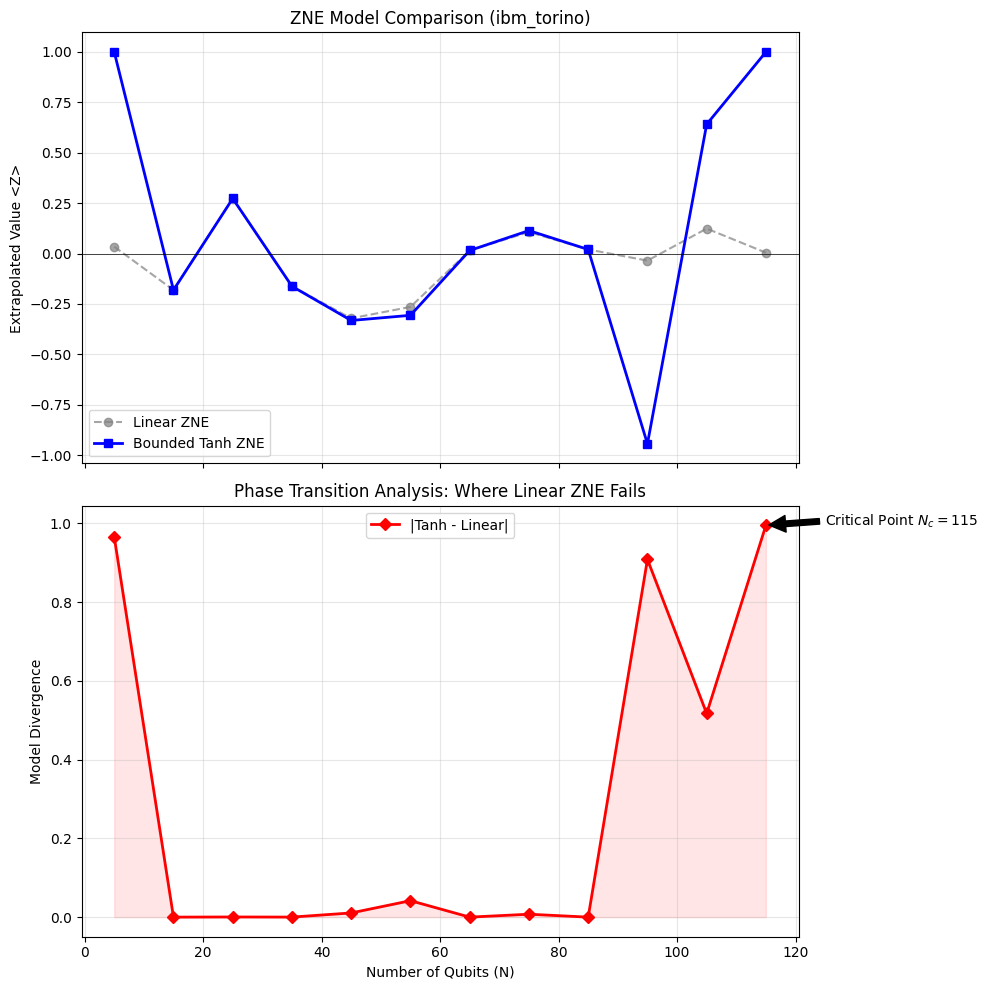

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
import os
import warnings

# Qiskit Imports
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. EXPERIMENT CONFIGURATION ---
API_KEY = "your api here"
BACKEND_NAME = "ibm_torino"

# Granular sweep to catch the exact peak of the phase transition
QUBIT_SCALES = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125]

# High precision settings
SHOTS = 10000  # Increased for stability
# Dense sampling for robust curve fitting (7 points for 3 parameters)
NOISE_FACTORS = [1, 1.5, 2, 3, 4, 5, 7]

RESULTS_FILE = "zne_phase_transition_data.json"

# --- 2. MODEL DEFINITIONS ---

def tanh_model(x, a, b, c):
    """ f(x) = a + b * tanh(c * x) """
    return a + b * np.tanh(c * x)

def fit_models(noise_factors, raw_evs):
    """
    Fits both Linear and Bounded Tanh models.
    Returns: (linear_zne, tanh_zne, tanh_params)
    """
    x = np.array(noise_factors)
    y = np.array(raw_evs)

    # --- A. Linear Fit ---
    slope, intercept = np.polyfit(x, y, 1)
    linear_zne = intercept

    # --- B. Bounded Tanh Fit ---
    # Bounds: a=[-1,1], b=[-2,2], c=[0, 5]
    # This prevents the "infinite spike" instability
    lower = [-1.0, -2.0, 0.0]
    upper = [ 1.0,  2.0, 5.0]

    # Guess based on first data point
    p0 = [y[0], -0.1, 0.5]

    try:
        popt, _ = curve_fit(tanh_model, x, y, p0=p0, bounds=(lower, upper), maxfev=5000)
        tanh_zne = popt[0] # a
        params = popt.tolist()
    except:
        tanh_zne = None
        params = []

    return linear_zne, tanh_zne, params

# --- 3. JOB EXECUTION ---

def run_point(backend, n_qubits):
    print(f"\n[Status] Processing {n_qubits} Qubits...")

    # Circuit: Linear Entanglement (Hardware Efficient)
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=n_qubits, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    # Transpile
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pm.run(circuit)

    # Observable: Z on last qubit
    observable = SparsePauliOp(["I" * (n_qubits - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # Random params (Seed fixed for consistency across scales)
    np.random.seed(42)
    params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

    # Options
    options = EstimatorOptions()
    options.default_shots = SHOTS
    options.resilience_level = 2
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = NOISE_FACTORS
    options.resilience.zne.extrapolator = "linear" # We interpret raw data manually

    # Run
    estimator = Estimator(mode=backend, options=options)
    print(f" > Submitting Job (Noise Factors: {NOISE_FACTORS})...")
    job = estimator.run([(isa_circuit, [isa_observable], [params])])
    print(f" > Job ID: {job.job_id()}")

    result = job.result()
    raw_evs = result[0].data.evs_noise_factors[0].flatten().tolist()
    return raw_evs

# --- 4. MAIN LOOP ---

def main():
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    backend = service.backend(BACKEND_NAME)

    print(f"--- STARTING PHASE TRANSITION STUDY ON {BACKEND_NAME} ---")

    data_store = {}
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            data_store = json.load(f)
            print(" > Resuming from saved file...")

    for n in QUBIT_SCALES:
        sn = str(n)
        if sn in data_store:
            continue

        try:
            # 1. Get Data
            raw_evs = run_point(backend, n)

            # 2. Fit
            lin_val, tanh_val, t_params = fit_models(NOISE_FACTORS, raw_evs)

            # 3. Calculate Divergence
            divergence = 0.0
            if tanh_val is not None:
                divergence = abs(tanh_val - lin_val)

            print(f"[{n} Qubits] Divergence: {divergence:.4f} (Lin={lin_val:.3f}, Tanh={tanh_val if tanh_val else 'Fail':.3f})")

            # 4. Save
            data_store[sn] = {
                "noise_factors": NOISE_FACTORS,
                "raw_evs": raw_evs,
                "linear_zne": lin_val,
                "tanh_zne": tanh_val,
                "divergence": divergence,
                "tanh_params": t_params
            }
            with open(RESULTS_FILE, 'w') as f:
                json.dump(data_store, f, indent=4)

        except Exception as e:
            print(f" ! Error at {n} qubits: {e}")

    plot_phase_transition(data_store)

# --- 5. VISUALIZATION ---

def plot_phase_transition(data):
    qubits = []
    linear_vals = []
    tanh_vals = []
    divergences = []

    sorted_keys = sorted(data.keys(), key=lambda x: int(x))
    for k in sorted_keys:
        item = data[k]
        if item['tanh_zne'] is not None:
            qubits.append(int(k))
            linear_vals.append(item['linear_zne'])
            tanh_vals.append(item['tanh_zne'])
            divergences.append(item['divergence'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Subplot 1: Absolute Values (The raw comparison)
    ax1.plot(qubits, linear_vals, 'o--', color='gray', label='Linear ZNE', alpha=0.7)
    ax1.plot(qubits, tanh_vals, 's-', color='blue', label='Bounded Tanh ZNE', linewidth=2)
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.set_ylabel("Extrapolated Value <Z>")
    ax1.set_title(f"ZNE Model Comparison ({BACKEND_NAME})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: The Divergence Envelope (Phase Transition)
    ax2.plot(qubits, divergences, 'D-', color='red', linewidth=2, label='|Tanh - Linear|')
    ax2.fill_between(qubits, divergences, color='red', alpha=0.1)

    # Labeling the likely peak
    if len(divergences) > 0:
        max_div = max(divergences)
        max_idx = divergences.index(max_div)
        peak_qubit = qubits[max_idx]
        ax2.annotate(f'Critical Point $N_c={peak_qubit}$',
                     xy=(peak_qubit, max_div),
                     xytext=(peak_qubit+10, max_div),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    ax2.set_ylabel("Model Divergence")
    ax2.set_xlabel("Number of Qubits (N)")
    ax2.set_title("Phase Transition Analysis: Where Linear ZNE Fails")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("zne_phase_transition_analysis.png")
    print("\nAnalysis Plot saved to 'zne_phase_transition_analysis.png'")

if __name__ == "__main__":
    main()